### 연관구매 분석(지원)
**1. 자료 업로드(Oracle $\to$ BigQuery)**
  + [ ] Oracle 자료 불러오기
  + [ ] 자료 업로드
  + [ ] 동시구매 Query 작성
---
**2. 조회 쿼리 작성(in BigQuery)**
  + [ ] basket by SKU
  + [ ] basket by CATEGORY
  + [ ] basket by BRAND
---
**3. ML 모델링 적용(in BigQuery)**
  + TEB(현재 비용대비 10배 상승?)


In [1]:
#######
# import
###
import cx_Oracle as oci
import pandas as pd

from matplotlib import pyplot as plt

import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns

%matplotlib inline
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import xlrd
from os import listdir
from datetime import datetime, timedelta
import glob

import pandas_gbq
import time 
import re
from google.cloud import bigquery


In [2]:
import os
os.environ["NLS_LANG"] = ".AL32UTF8"      #encodring이 UTF-8 인 경우

In [5]:
# data 준비

# DB접속 : 접속정보 읽기
con_text = open("C:/Users/MAEIL/conn_info_MMBSHIP.txt", 'r', encoding='utf8')
con_text = con_text.read()

# DB 접속 : 실제 접속
conn = oci.connect(con_text[1:], encoding='UTF-8', nencoding='UTF-8')

In [6]:
# query run
query0= '''
        select M.판매처, substr(M.배정일,1,6) as reg_dt, count(*)
        from mmbship.lkh_emp_master M, mmbship.lkh_emp_PRODUCT P
        where trim(M.상품명) = trim(P.prod_nm)
        and M.상품명 not like '%판촉물%'
        and M.배정일 like '202211%'
        group by M.판매처, substr(M.배정일,1,6)
        order by 3 desc
        '''
df_test = pd.read_sql(query0, con = conn )


In [54]:
df_test.head(10)

,판매처,REG_DT,COUNT(*)
0,네이버(직영),202211,229957
1,카카오선물하기,202211,55635
2,카카오쇼핑하기,202211,33607
3,쿠팡 아이템마켓(직영),202211,14339
4,(HN)셀렉스몰,202211,14008
5,연금매장(V),202211,8072
6,한국인삼공사(정관장몰),202211,7222
7,SSG닷컴(직영),202211,5695
8,다이렉트몰,202211,5316
9,올리브영,202211,4136


In [37]:
# query run
query1= '''
select P.PROD_CODE, trim(P.PROD_NM) as PROD_NM, trim(P.PROD_CTGR) as PROD_CTGR,  trim(P.PROD_BRND) as PROD_BRND 
, M.판매처 as channel, 주문번호 as order_no, to_date(M.배정일, 'YYYYMMDD') as reg_dtm
from mmbship.lkh_emp_master M, mmbship.lkh_emp_PRODUCT P
where trim(M.상품명) = trim(P.prod_nm)
and M.상품명 not like '%판촉물%'
and M.판매처 = '네이버(직영)'
and M.배정일 like '202211%'
        '''
df0 = pd.read_sql(query1, con = conn )
df0 = df0.drop_duplicates().reset_index(drop=True)

In [38]:
df0.tail(2)

,PROD_CODE,PROD_NM,PROD_CTGR,PROD_BRND,CHANNEL,ORDER_NO,REG_DTM
229037,107109,셀렉스 세라마이드콜라겐음료 [ 125ML ] [ 4X6 ],건강식,셀렉스,네이버(직영),2022113099814241,2022-11-30
229038,107201,셀렉스 프로틴 음료 [ 오리지널 ] [ 190ML ],건강식,셀렉스,네이버(직영),2022112999152431,2022-11-30


In [39]:
# 접속 정보 : local
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="C:/Users/MAEIL/OneDrive - 매일유업/auto_send/boxwood-chassis-356100-a2ec31483acb.json"
client = bigquery.Client()
project = 'boxwood-chassis-356100'
dataset_id = 'EMP'
table_id = 'BASKET_ANALYSIS'
table_name = dataset_id +'.' +table_id

pandas_gbq.to_gbq(df0, table_name, project_id=project, if_exists = 'append' )

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [45]:
# 자료 업로드 현황 확인

sql = """
    SELECT FORMAT_DATETIME('%y/%m', CAST(REG_DTM AS DATETIME)) as DATE
    , min(FORMAT_DATETIME('%y/%m/%d', CAST(REG_DTM AS DATETIME))) as DATE_min
    , max(FORMAT_DATETIME('%y/%m/%d', CAST(REG_DTM AS DATETIME))) as DATE_max
    , count(*)
    FROM `boxwood-chassis-356100.EMP.BASKET_ANALYSIS`
    where CAST(REG_DTM AS DATETIME) between DATE_SUB(current_date(), INTERVAL 4 month ) and DATE_SUB(current_date(), INTERVAL 0 month)
    group by FORMAT_DATETIME('%y/%m', CAST(REG_DTM AS DATETIME))
    """
df_search = client.query(sql).to_dataframe()

In [46]:
df_search

,DATE,DATE_min,DATE_max,f0_
0,22/10,22/10/01,22/10/31,198797
1,22/11,22/11/01,22/11/30,229039
2,22/09,22/09/05,22/09/30,195331


In [26]:
# query run
query1= '''
        with target_product as (
            select 주문번호 as order_no
            from mmbship.lkh_emp_master
            where 상품명 not like '%판촉물%'
            and 판매처 = '네이버(직영)'
            and 상품명 like '%어메이징%'
            and 배정일 like '202210%' 
            and 회원고유번호 is not null
            and 회원고유번호 <> '0')
        select 주문번호 as order_no
        , 상품명 as product_nm
        , to_date(배정일, 'YYYYMMDD') as reg_dtm 
        from mmbship.lkh_emp_master M, target_product P
        where M.주문번호 = P.order_no
        and 상품명 not like '%판촉물%'
        and 판매처 = '네이버(직영)'
        and 배정일 like '202210%'
        and 회원고유번호 is not null
        and 회원고유번호 <> '0'
        '''
df = pd.read_sql(query1, con = conn )

In [27]:
df = df.drop_duplicates().reset_index(drop=True)

In [28]:
df.tail(2)

,ORDER_NO,PRODUCT_NM,REG_DTM
18865,2022102750679201,멸균 소잘우유 [ 저지방 ] [ 190ml ],2022-10-27
18866,2022102748986711,멸균 소잘우유 [ 저지방 ] [ 190ml ],2022-10-27


In [30]:
pd.DataFrame((pd.DataFrame(df.groupby('ORDER_NO')['PRODUCT_NM'].count()).reset_index()).groupby('PRODUCT_NM')['ORDER_NO'].count())

,ORDER_NO
PRODUCT_NM,
1,12590
2,1523
3,436
4,188
5,95
6,48
7,25
8,11
9,9


In [11]:
# query run
query1= '''
        with buy_group as (
            select distinct M.회원고유번호 as unfy_mmb_no, 수령자전화 as cellno
            from mmbship.lkh_emp_master M
            where 판매처 = '네이버(직영)'
            and 상품명 like '%어메이징%')
        select B.*
        from buy_group B
        '''
df = pd.read_sql(query1, con = conn )
df

,UNFY_MMB_NO,CELLNO
0,238,010-6375-5659
1,271,010-6356-2157
2,280,0502-3313-7349
3,335,010-8588-4833
4,361,010-4411-5566
...,...,...
138458,4177177,0502-3409-8472
138459,4177177,0502-3462-0238
138460,4177177,0503-6950-6862
138461,4177177,0507-1881-3097


In [9]:
# query run
query1= '''
        with buy_group as (
            select distinct M.회원고유번호 as unfy_mmb_no, 수령자전화 as cellno
            from mmbship.lkh_emp_master M
            where 판매처 = '네이버(직영)'
            and 상품명 like '%어메이징%')
        select I.*
        from tm_mmb_info I, buy_group B
        where I.unfy_mmb_no = B.unfy_mmb_no
        and to_char(I.reg_dtm,'YYYYMMDD') between '20221001' and '20230224' 
        '''
df = pd.read_sql(query1, con = conn )

In [10]:
df

,UNFY_MMB_NO,CUST_NO,MMB_NM,MMB_ID,FRNR_DV_CD,BTDY,BTDY_LUCR_SOCR_DV_CD,GNDR_DV_CD,SEF_CERT_DI,SEF_CERT_CI_VER,...,CBL_TEL_NO3,EML_ADDR,CRD_NO,CRD_REG_DTM,ADDR_FLAG,NTRY_STOR_NO,REG_DTM,UPD_DTM,UNFY_MMB_NO,CELLNO


In [32]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [31]:
df.tail(2)

,ORDER_NO,PRODUCT_NM,REG_DTM
18865,2022102750679201,멸균 소잘우유 [ 저지방 ] [ 190ml ],2022-10-27
18866,2022102748986711,멸균 소잘우유 [ 저지방 ] [ 190ml ],2022-10-27


In [34]:
basket = pd.crosstab(df["ORDER_NO"], df["PRODUCT_NM"],  df["REG_DTM"], aggfunc='count').fillna(0).sort_values(by ='ORDER_NO', ascending = True)

In [35]:
basket

PRODUCT_NM,[ 냉동 ] [ 선물세트 ] 소잘우유+순우유 케이크 [ 730G ],[ 냉동 ] [ 선물세트 ] 소잘초코+순우유 케이크 [ 750G ],[ 냉동 ] 검은콩 롤케이크 [ 110G ],[ 냉동 ] 딸기요거트 [ 롤케이크 ] [ 370G ],[ 냉동 ] 딸기요거트 [ 미니롤케이크 ] [ 110G ],[ 냉동 ] 매일두유 롤케이크 [ 110G ],[ 냉동 ] 미니 바스크 치즈케이크 4종 [ 140G X 4 ],[ 냉동 ] 밀크 케이크 [ 400G ],[ 냉동 ] 바스크치즈케이크 [ 470G ],[ 냉동 ] 상하아이스크림 [ 딸기 ] [ 컵 ] [ 100ML ],...,페레로 [ 킨더부에노 ] [ 화이트 ] [ T2 X 3 ],페레로 [ 킨더부에노 ] [ 화이트 ] [ T2 ],페레로 [ 킨더조이 ] [ 블루 ] [ 제네릭 ] [ T3 ],페레로 [ 킨더초콜릿 ] [ T4 ],페레로 [ 킨더초콜릿 ] [ T8 ],페레로 [ 킨더초콜릿 ] [ 미니 ] [ T20 ],핑크퐁 X 요미쌀과자 [ 브로콜리 ] [ 1단계 ] [ 25G ],핑크퐁X요미 미니팝 [ 구운옥수수 ] [ 25G ],핑크퐁X요미 미니팝 [ 딸기요거트 ] [ 25G ],핑크퐁X요미 미니팝 [ 트리플치즈 ] [ 25G ]
ORDER_NO,,,,,,,,,,,,,,,,,,,,,
2022092984329261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022092991946891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022093011331511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022093011753231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022093015433641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022103131222541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022103131240611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022103131258581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
%%time 

df_array_user = basket.values
df_array_category = basket.T.values

from sklearn.decomposition import TruncatedSVD

# 차원축소
SVD = TruncatedSVD(n_components=12)
SVD_matrix_user = SVD.fit_transform(df_array_user)
SVD_matrix_category = SVD.fit_transform(df_array_category)
# SVD_matrix.shape


Wall time: 1.71 s


In [37]:
corr_SVD_user = np.corrcoef(SVD_matrix_user)

In [38]:
# 상관관계
# corr_SVD_user = np.corrcoef(SVD_matrix_user)
corr_SVD_category = np.corrcoef(SVD_matrix_category)
# corr_SVD_user.shape

In [39]:
#자료 확인
corr_SVD_user.shape, corr_SVD_category.shape

((14931, 14931), (263, 263))

In [40]:
df_svd_preds = pd.DataFrame(corr_SVD_user)

In [42]:
indices = pd.Series(basket.index, index=df_svd_preds.index).drop_duplicates()
df_indices = pd.DataFrame(indices).reset_index()
df_indices = df_indices.rename(columns = {'index' : 'userId'})

In [43]:
target = list(df_indices['userId'])

In [63]:
%%time 

df_indices_result =[]

for i in range(0, len(target)):
    # 개인을 선택
    user_row_number = i

    # 선택한 개인의 회원번호
    userId = indices.loc[user_row_number]

    # 유사 인원에 대한 정렬
    sorted_user_predictions = df_svd_preds[user_row_number].sort_values(ascending = False)
    sorted_user_predictions = pd.DataFrame(sorted_user_predictions).reset_index()
    sorted_user_predictions = sorted_user_predictions.rename(columns = {'index' : 'userId', 1 : 'Predictions'})

    #구매 내용에서, 해당고객 추출(ex. 0-> 5369763)
    user_data = df[df.ORDER_NO == userId]
    user_history = pd.DataFrame(user_data.groupby(['ORDER_NO', 'PRODUCT_NM'])['REG_DTM'].count().reset_index())

    # 구매한 제품은 제외
    recommandations = df[~df['PRODUCT_NM'].isin(user_history['PRODUCT_NM'])]

    # 제품과 유사도 내용을 합친다
    recommandations = recommandations.merge(df_indices, on ='ORDER_NO')
    recommandations = recommandations.merge(sorted_user_predictions, on ='userId').rename(columns = {'index' : 'userId', i : 'Predictions'})
    recommandations = recommandations.sort_values(by ='Predictions', ascending = False)

    #제품별 중복 제거
    recommandations = recommandations[['PRODUCT_NM']].drop_duplicates(['PRODUCT_NM'])[:3]
    recommandations = recommandations.T.values

    #3개 제품만 선택
#     recommandations = recommandations[['CATEGORY_CODE']].drop_duplicates(['CATEGORY_CODE'])[:3]
    df_indices_result.append(recommandations)

Wall time: 12min 38s


In [64]:
df_indices['RECOMMEND'] =''
for i in range(0, len(df_indices_result)):
    df_indices['RECOMMEND'][i] = df_indices_result[i]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
df_indices.tail()

,userId,ORDER_NO,RECOMMEND
14926,14926,2022103131222541,"[[요미 유기농 주스 [ 4본 ] [ 사과배 ] [ 125ML ], 분유 앱솔루트 ..."
14927,14927,2022103131240611,"[[요미 유기농 주스 [ 4본 ] [ 사과배 ] [ 125ML ], 분유 앱솔루트 ..."
14928,14928,2022103131258581,"[[요미 유기농 주스 [ 4본 ] [ 사과배 ] [ 125ML ], 분유 앱솔루트 ..."
14929,14929,2022103131270871,"[[요미 유기농 주스 [ 4본 ] [ 사과배 ] [ 125ML ], 분유 앱솔루트 ..."
14930,14930,2022103131291011,"[[[ 냉동 ] 바스크치즈케이크 [ 470G ], 페레로 [ 로쉐 ] [ T24 ]..."


In [66]:
# Excel 저장
name = '230102_고객성향분석_네이버_v3.xlsx'
df_indices.to_excel(name, sheet_name= 'SVD' )

In [ ]:
df_array_user = df_table.values
df_array_category = df_table.T.values

from sklearn.decomposition import PCA

# 차원축소
PCA = PCA(n_components=12)
PCA_matrix_user = PCA.fit_transform(df_array_user)
PCA_matrix_category = PCA.fit_transform(df_array_category)
# SVD_matrix.shape

# 상관관계
corr_PCA_user = np.corrcoef(PCA_matrix_user)
corr_PCA_category = np.corrcoef(PCA_matrix_category)
# corr_SVD_user.shape

df_pca_preds = pd.DataFrame(corr_PCA_user)

indices = pd.Series(df_table.index, index=df_pca_preds.index).drop_duplicates()
df_indices = pd.DataFrame(indices).reset_index()
df_indices = df_indices.rename(columns = {'index' : 'userId'})

In [ ]:
%%time 

df_indices_result =[]

for i in range(0, len(target)):
    # 개인을 선택
    user_row_number = i

    # 선택한 개인의 회원번호
    userId = indices.loc[user_row_number]

    # 유사 인원에 대한 정렬
    sorted_user_predictions = df_pca_preds[user_row_number].sort_values(ascending = False)
    sorted_user_predictions = pd.DataFrame(sorted_user_predictions).reset_index()
    sorted_user_predictions = sorted_user_predictions.rename(columns = {'index' : 'userId', 1 : 'Predictions'})

    #구매 내용에서, 해당고객 추출(ex. 0-> 5369763)
    user_data = df1_simple[df1_simple.MEMBER_NO == userId]
    user_history = pd.DataFrame(user_data.groupby(['MEMBER_NO', 'PRM_PRODUCT_CODE'])['PRODUCT_COUNT'].sum().reset_index())

    # 구매한 제품은 제외
    recommandations = df1_simple[~df1_simple['PRM_PRODUCT_CODE'].isin(user_history['PRM_PRODUCT_CODE'])]

    # 제품과 유사도 내용을 합친다
    recommandations = recommandations.merge(df_indices, on ='MEMBER_NO')
    recommandations = recommandations.merge(sorted_user_predictions, on ='userId').rename(columns = {'index' : 'userId', i : 'Predictions'})
    recommandations = recommandations.sort_values(by ='Predictions', ascending = False)

    #제품별 중복 제거
    recommandations = recommandations[['PRM_PRODUCT_CODE']].drop_duplicates(['PRM_PRODUCT_CODE'])[:3]
    recommandations = recommandations.T.values

    #3개 제품만 선택
#     recommandations = recommandations[['CATEGORY_CODE']].drop_duplicates(['CATEGORY_CODE'])[:3]
    df_indices_result.append(recommandations)

Wall time: 23min 8s


In [ ]:
df_indices['RECOMMEND'] =''
for i in range(0, len(df_indices_result)):
    df_indices['RECOMMEND'][i] = df_indices_result[i]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_indices.tail()

,userId,MEMBER_NO,RECOMMEND
9830,9830,970022,"[[179799, 270717, 170081]]"
9831,9831,971560,"[[179333, 270591, 270990]]"
9832,9832,973510,"[[179966, 179203, 179968]]"
9833,9833,973893,"[[179982, 271011, 179760]]"
9834,9834,998207,"[[179767, 179376, 179876]]"


In [ ]:
# Excel 저장

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('200721_고객성향분석_direct_v2.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
df_indices_SDV.to_excel(writer, sheet_name= 'SDV' )
df_indices_PCA.to_excel(writer, sheet_name= 'PCA' )

# Close the Pandas Excel writer and output the Excel file.
writer.save()

### 4.결과 비교 : SDV vs PCA
: 처음 column이 내용을 잘 설명한다는 것을 가정함

In [ ]:
def graph_corr(i,j):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.scatter(corr_SVD_user[:,i], corr_SVD_user[:,j])
    plt.subplot(1,2,2); plt.scatter(corr_PCA_user[:,i], corr_PCA_user[:,j])
    plt.show()

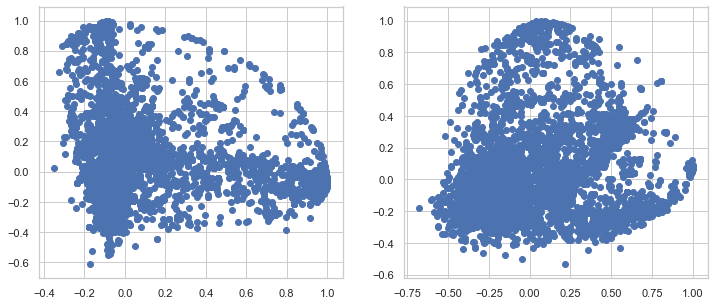

In [ ]:
# 모형의 차이 : sample1
graph_corr(0,1)

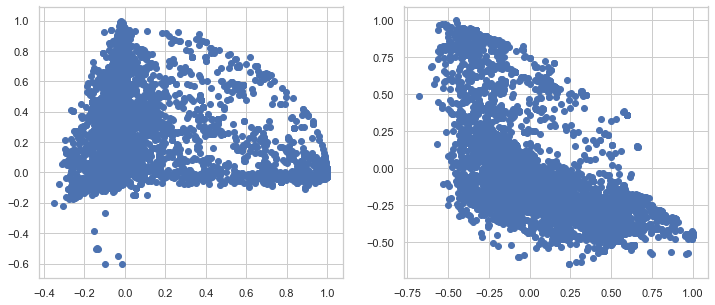

In [ ]:
# 모형의 차이 : sample1
graph_corr(0,2)

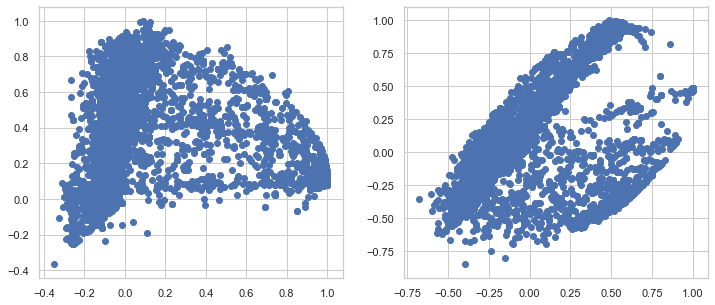

In [ ]:
# 모형의 차이 : sample1
graph_corr(0,3)

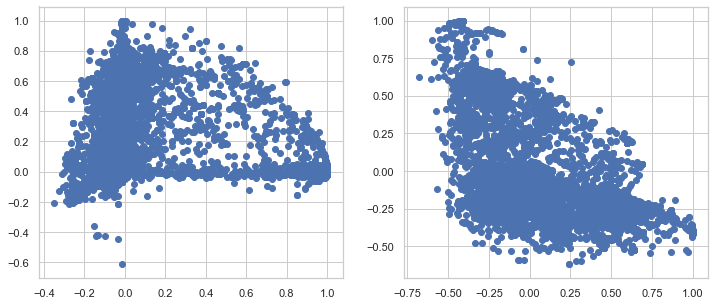

In [ ]:
# 모형의 차이 : sample4
graph_corr(0,-3)

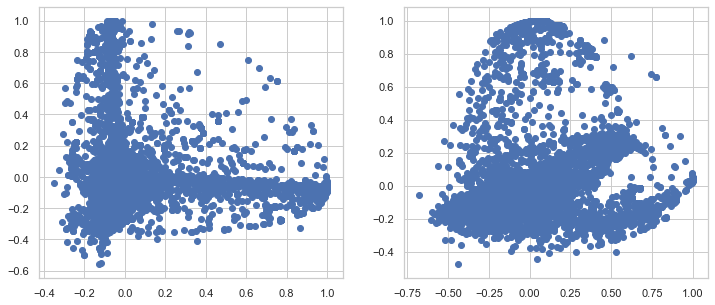

In [ ]:
# 모형의 차이 : sample5
graph_corr(0,-2)

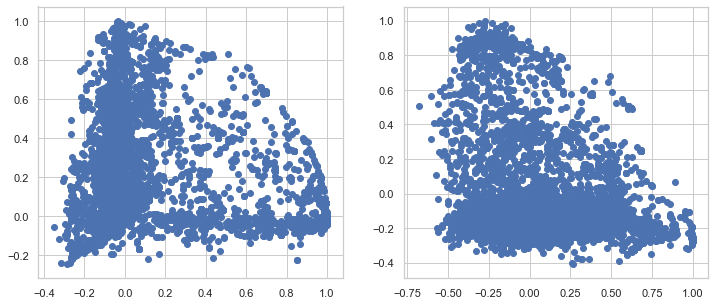

In [ ]:
# 모형의 차이 : sample1
graph_corr(0,-1)

In [50]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_sets = basket.applymap(encode_units)
# basket_sets.drop('POSTAGE', inplace=True, axis=1)
# basket_sets

In [55]:
frequent_itemsets = apriori(basket_sets, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
# rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


In [59]:
rules[ (rules['lift'] >= 1) &
      (rules['confidence'] >= 0.2) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
